In [1]:
%%capture capt
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.utils import get_laplacian

from mewisPool_layer import MLP, MEWISPool

# Define Models

In [3]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, device):
        super(Net, self).__init__()

        self.gc1 = GINConv(MLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim))
        self.pool1 = MEWISPool(hidden_dim=hidden_dim, device=device)
        
        self.gc2 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim))
        self.pool2 = MEWISPool(hidden_dim=hidden_dim, device=device)
        
        self.gc3 = GINConv(MLP(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=hidden_dim))
        
        self.fc1 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.gc1(x, edge_index))

        x_pooled, edge_index_pooled, batch_pooled, loss1 = self.pool1(x, edge_index, batch)

        x_pooled = F.relu(self.gc2(x_pooled, edge_index_pooled))

        x_pooled, edge_index_pooled, batch_pooled, loss2 = self.pool2(x_pooled, edge_index_pooled,
                                                                                batch_pooled)

        x_pooled = self.gc3(x_pooled, edge_index_pooled)
        # readout = global_mean_pool(x_pooled, batch_pooled)
        readout = torch.cat([x_pooled[batch_pooled == i].mean(0).unsqueeze(0) for i in torch.unique(batch_pooled)],
                    dim=0)

        out = self.fc1(readout)
        out = torch.relu(out)
        out = self.fc2(out)

        return out, loss1 + loss2

# Apply on MUTAG

### Load data

In [4]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

In [5]:
torch.manual_seed(42)

path = 'data'
dataset = TUDataset(path, name='MUTAG', use_node_attr=True, use_edge_attr=True).shuffle()

input_dim = dataset.num_features
num_classes = dataset.num_classes

In [6]:
BATCH_SIZE = 20
VAL_PCT = 0.15
TEST_PCT = 0.1

n_train = int(len(dataset) * (1 - VAL_PCT - TEST_PCT))
n_val = int(len(dataset) * VAL_PCT)

train_dataset = dataset[:n_train]
val_dataset = dataset[n_train: n_train+n_val]
test_dataset = dataset[n_train+n_val:]

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f'{len(train_dataset)} training samples, {len(val_dataset)} validation samples, {len(test_dataset)} test samples.')

141 training samples, 28 validation samples, 19 test samples.


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

Using cuda


### Load model architectures

In [8]:
hidden_dim = 32
nb_epochs = 200
learning_rate = 3e-4
weight_decay = 1e-5
scheduler_patience = 10
scheduler_factor = 1e-3
patience = 50

In [9]:
model = Net(input_dim=input_dim, 
            hidden_dim=hidden_dim, num_classes=num_classes, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       patience=scheduler_patience,
                                                       factor=scheduler_factor,
                                                       verbose=True)
criterion = torch.nn.CrossEntropyLoss()

### Train models

In [10]:
def validate(model, val_loader, criterion, device):
    val_loss = 0.
    val_corrects = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            data = data.to(device)
            out, loss_pool = model(data.x, data.edge_index, data.batch)
            loss_classification = criterion(out, data.y.view(-1))
            loss = loss_classification + 0.01 * loss_pool
            val_loss += loss.item()
            val_corrects += out.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_corrects / len(val_dataset)
    return val_loss, val_acc

In [11]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    train_loss = 0.
    train_corrects = 0
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out, loss_pool = model(data.x, data.edge_index, data.batch)
        loss_classification = criterion(out, data.y.view(-1))
        loss = loss_classification + 0.01 * loss_pool

        loss.backward()
        train_loss += loss.item()
        train_corrects += out.max(dim=1)[1].eq(data.y.view(-1)).sum().item()
        optimizer.step()

    train_loss /= len(train_loader)
    train_acc = train_corrects / len(train_dataset)
    scheduler.step(train_loss)
    return train_loss, train_acc

In [12]:
def train(model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, nb_epochs, patience, device,
         print_every=None):

    best_val_loss = float('inf')
    counter = 0

    train_losses,  val_losses, test_losses = [], [], []
    train_accs, val_accs, test_accs = [], [], []

    if print_every is None:
        print_every = 1 if nb_epochs <= 20 else int(nb_epochs/20)

    for epoch in range(nb_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        test_loss, test_acc = validate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)

        if epoch % print_every == 0 or epoch == nb_epochs - 1:
            print(f"Epoch [{epoch}/{nb_epochs}], Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Test loss: {test_loss:.3f},"
                  f" Train acc: {train_acc:.2f}, Val acc: {val_acc:.2f}, Test acc: {test_acc:.2f}")

        # Early-Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Early stopping
        if counter > patience:
            print(f'======== Early stopping at Epoch {epoch} ========')
            if epoch % print_every != 0:
                    print(f"Epoch [{epoch}/{nb_epochs}], Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Test loss: {test_loss:.3f},"
                          f" Train acc: {train_acc:.2f}, Val acc: {val_acc:.2f}, Test acc: {test_acc:.2f}")
            break

    return train_losses, val_losses, test_losses, train_accs, val_accs, test_accs

In [13]:
train_losses, val_losses, test_losses, train_accs, val_accs, test_accs = train(
    model, criterion, optimizer, scheduler, train_loader, val_loader, test_loader, 
    nb_epochs, patience, device, print_every=1)

Epoch [0/200], Train loss: 3.797, Val loss: 3.679, Test loss: 4.530, Train acc: 0.28, Val acc: 0.43, Test acc: 0.29
Epoch [1/200], Train loss: 3.607, Val loss: 4.093, Test loss: 4.987, Train acc: 0.32, Val acc: 0.43, Test acc: 0.29
Epoch [2/200], Train loss: 3.467, Val loss: 4.139, Test loss: 4.985, Train acc: 0.35, Val acc: 0.57, Test acc: 0.43
Epoch [3/200], Train loss: 3.360, Val loss: 3.970, Test loss: 4.865, Train acc: 0.47, Val acc: 0.79, Test acc: 0.50
Epoch [4/200], Train loss: 3.274, Val loss: 3.177, Test loss: 4.007, Train acc: 0.52, Val acc: 0.75, Test acc: 0.50
Epoch [5/200], Train loss: 3.219, Val loss: 2.769, Test loss: 3.280, Train acc: 0.65, Val acc: 0.89, Test acc: 0.57
Epoch [6/200], Train loss: 3.131, Val loss: 2.341, Test loss: 2.668, Train acc: 0.61, Val acc: 0.75, Test acc: 0.54
Epoch [7/200], Train loss: 3.051, Val loss: 2.204, Test loss: 2.575, Train acc: 0.72, Val acc: 0.86, Test acc: 0.57
Epoch [8/200], Train loss: 2.957, Val loss: 2.144, Test loss: 2.615, Tra

### Plot metrics

In [14]:
def plot_metrics(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, suptitle=''): 
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')
    axs[0].plot(test_losses, label='Test Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()
    axs[0].grid('on')
    
    # Plot accuracies
    axs[1].plot(train_accs, label='Train Acc')
    axs[1].plot(val_accs, label='Val Acc')
    axs[1].plot(test_accs, label='Test Acc')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    axs[1].grid('on')
    
    plt.tight_layout()
    plt.suptitle(suptitle)
    
    plt.show()

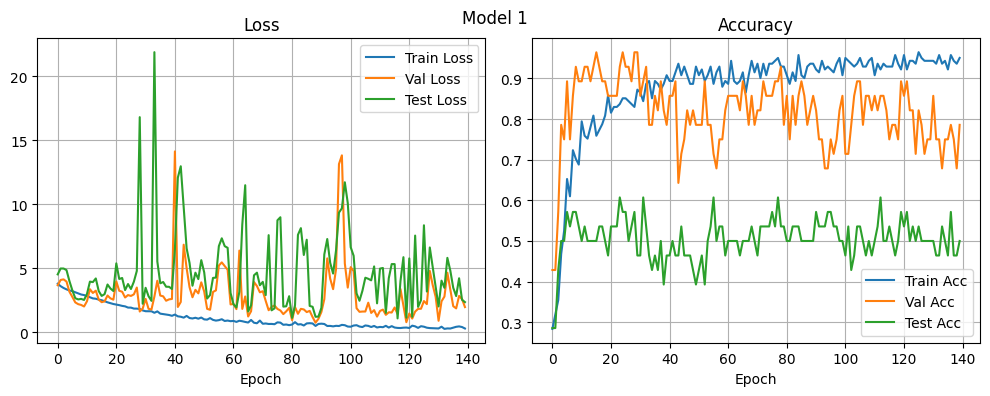

In [15]:
plot_metrics(train_losses, val_losses, test_losses, train_accs, val_accs, test_accs, suptitle='Model 1')